In [1]:
!conda install -q -y gdown

Solving environment: ...working... done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - gdown


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.13.0               |   py37h89c1867_1         989 KB  conda-forge
    filelock-3.7.1             |     pyhd8ed1ab_0          12 KB  conda-forge
    gdown-4.4.0                |     pyhd8ed1ab_0          16 KB  conda-forge
    ------------------------------------------------------------
                                           Total:        1017 KB

The following NEW packages will be INSTALLED:

  filelock           conda-forge/noarch::filelock-3.7.1-pyhd8ed1ab_0
  gdown              conda-forge/noarch::gdown-4.4.0-pyhd8ed1ab_0

The following packages will be UPDATED:

  conda                               4.12.0-py37h89c1867_0 --> 4.13.0-py37h89c1867_1


Preparing transaction: ...working... done
V

In [2]:
!gdown --id 1QMVLpqag6S9JWqzmGM_pK4C0F1eBVIfV

/opt/conda/lib/python3.7/site-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1QMVLpqag6S9JWqzmGM_pK4C0F1eBVIfV
To: /kaggle/working/Model_I.tgz
100%|███████████████████████████████████████| 1.99G/1.99G [00:13<00:00, 148MB/s]


In [3]:
!pip install -q timm

In [4]:
import tarfile
import os
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,3)

In [5]:
file = tarfile.open('Model_I.tgz')
file.extractall("data/")

In [6]:
os.listdir("./data/Model_I")

['cdm', 'axion', 'no_sub']

In [7]:
cls1 = os.listdir("./data/Model_I/cdm")
cls2 = os.listdir("./data/Model_I/no_sub")
cls3 = os.listdir("./data/Model_I/axion")

In [8]:
cls1 = ['./data/Model_I/cdm/' + i for  i in cls1 ]
cls2 = ['./data/Model_I/no_sub/' + i for  i in cls2 ]
cls3 = ['./data/Model_I/axion/' + i for  i in cls3 ]

In [9]:
len(cls1) , len(cls2) , len(cls3)

(29772, 28856, 28897)

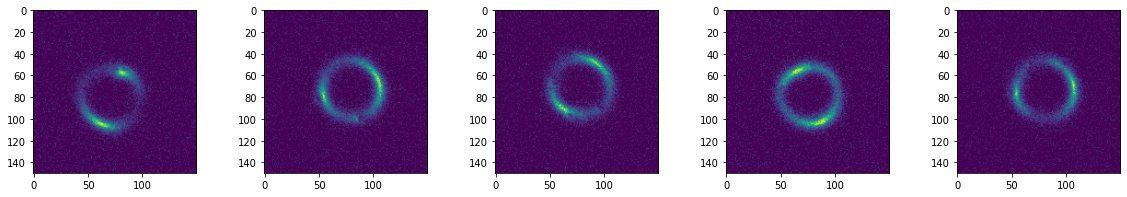

In [10]:
# class 1
fig, axs = plt.subplots(1, 5)
for i in range(5):
    try:
      axs[i].imshow(np.load(cls1[i],allow_pickle=True)[0]) 
    except:
      axs[i].imshow(np.load(cls1[i],allow_pickle=True)) 

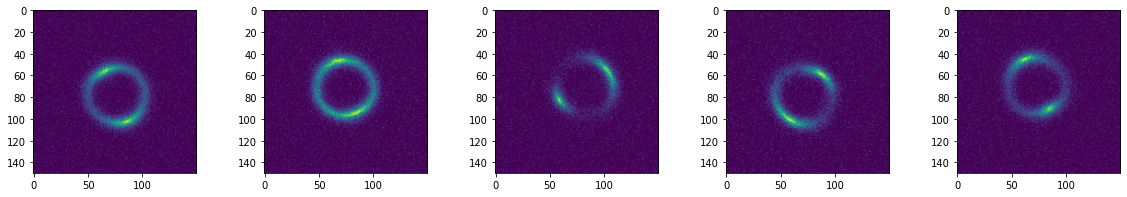

In [11]:
# class 2
fig, axs = plt.subplots(1, 5)
for i in range(5):
    axs[i].imshow(np.load(cls2[i])) 

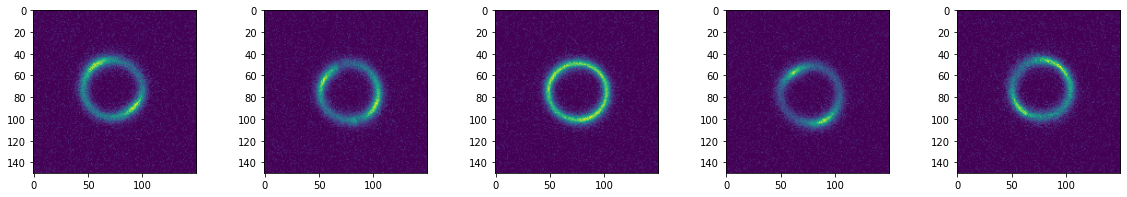

In [12]:
fig, axs = plt.subplots(1, 5)
for i in range(5):
    try:
      axs[i].imshow(np.load(cls3[i],allow_pickle=True)[0]) 
    except:
      axs[i].imshow(np.load(cls3[i],allow_pickle=True)) 

In [13]:
def func(paths,target):
    xx = np.array(paths)
    xx = np.expand_dims(xx,1)
    yy = np.zeros((len(xx),1)) + target
    gg = np.concatenate([xx,yy],axis = 1)
    return gg

In [14]:
d1 = func(cls1 , 0)
d2 = func(cls2 , 1)
d3 = func(cls3 , 2)

In [15]:
t_data = np.concatenate([d1,d2,d3] , axis = 0)

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
X, X_test = train_test_split(t_data, test_size=0.1, random_state=42) # 10% set to test data

In [18]:
X_train, X_val = train_test_split(X, test_size=0.25, random_state=42) 

In [19]:
X_train.shape , X_val.shape , X_test.shape

((59079, 2), (19693, 2), (8753, 2))

In [20]:
import timm
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm.notebook import tqdm
from sklearn import model_selection
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
import math
import random
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from torch import optim
from transformers import get_cosine_schedule_with_warmup
import warnings
warnings.filterwarnings('ignore')
from sklearn import  model_selection
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [21]:
def set_seed(seed):
    #Sets the seed for Reprocudibility
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
set_seed(42)


In [22]:
image_size = 150
train_aug = A.Compose(
    [  
        A.RandomCrop(80,80,p=0.5),
         A.HorizontalFlip(p=0.25),
        A.VerticalFlip(p=0.25),
        
        A.Resize(image_size,image_size,p=1.0),
        ToTensorV2()
    ]
)
val_aug = A.Compose(
    [ 
        A.Resize(image_size,image_size,p=1.0),
        ToTensorV2()
    ]
)

In [23]:
class Len(Dataset):
    def __init__(self , data , augs):
        self.data = data
        self.augs = augs
        
    def __len__(self):
        return(len(self.data))
    
    def __getitem__(self , idx):
        path = self.data[idx][0] 
        target = float(self.data[idx][1])
        
        if(target == 1 or target == 0):
            image = np.load(path)
        else:
            image = np.load(path,allow_pickle=True)[0]
              
        image = (image - np.min(image))/(np.max(image) - np.min(image))
        image = np.expand_dims(image , axis = 2)
        
        transformed = self.augs(image=image)       
        image = transformed['image']
        image = torch.tensor(image,dtype = torch.float32)      
        
        
        return image,torch.tensor(target).long() 

In [24]:
pretrained_model = 'tf_efficientnet_b2_ns'
class Model(nn.Module):
    def __init__(self,pretrained = True):
        super().__init__()
        self.backbone = timm.create_model(pretrained_model, pretrained=pretrained, num_classes=0,global_pool='',in_chans=1)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.lin = nn.Linear(1408,3)
        self.do = nn.Dropout(p=0.5)
    
    def forward(self,image):
        image = self.backbone(image)     
        image = self.pool(image)
        
        image = image.view(image.shape[0], -1)    
        image = self.do(image)
        image = self.lin(image)
        return image

In [25]:
class AverageMeter(object):
    #Computes and stores the average and current value
    def __init__(self):
        self.reset()
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [26]:
def train_one_epoch(train_loader,model,optimizer,criterion,e,epochs,scheduler):
    losses = AverageMeter()
    scores = AverageMeter()
    scoresx = AverageMeter()
    model.train()
    global_step = 0
    loop = tqdm(enumerate(train_loader),total = len(train_loader))
    
    for step,(image,labels) in loop:
        image = image.to(device)
        labels= labels.to(device)
        output2 = model(image)
        batch_size = labels.size(0)
        
        loss = criterion(output2,labels)
        
        out = output2.softmax(1)
        outputs = torch.argmax(out, dim=1).cpu().detach().numpy()
        targets = labels.cpu().detach().numpy()
        f1 = f1_score(targets, outputs , average='macro')
        acc = accuracy_score(targets, outputs)
        losses.update(loss.item(), batch_size)
        scores.update(f1.item(), batch_size)
        scoresx.update(acc.item(), batch_size)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        scheduler.step()
        global_step += 1
        
        loop.set_description(f"Epoch {e+1}/{epochs}")
        loop.set_postfix(loss = loss.item(), f1= f1.item(),acc= acc.item(), stage = 'train')
        
        
    return losses.avg,scores.avg,scoresx.avg

In [27]:
def val_one_epoch(loader,model,criterion):
    losses = AverageMeter()
    scores = AverageMeter()
    scoresx = AverageMeter()
    model.eval()
    global_step = 0
    loop = tqdm(enumerate(loader),total = len(loader))
    
    for step,(image, labels) in loop:
        image = image.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            output2 = model(image)
    
        loss = criterion(output2,labels)
      
        out = output2.softmax(1)
        outputs = torch.argmax(out, dim=1).cpu().detach().numpy()
        targets = labels.cpu().detach().numpy()
        f1 = f1_score(targets, outputs , average='macro')
        acc = accuracy_score(targets, outputs)
        losses.update(loss.item(), batch_size)
        scores.update(f1.item(), batch_size)
        scoresx.update(acc.item(), batch_size)
        loop.set_postfix(loss = loss.item(), f1= f1.item(),acc=acc.item(), stage = 'valid')
        
    return losses.avg,scores.avg,scoresx.avg

In [28]:
OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)


In [29]:
def fit(m,training_batch_size=64,validation_batch_size=64):
    

    train_data= Len(X_train , augs = train_aug)
    val_data  = Len(X_val , augs = val_aug)
    
    train_loader = DataLoader(train_data,
                             shuffle=True,
                        num_workers=4,pin_memory=True, drop_last=True,
                        batch_size=training_batch_size)
    valid_loader = DataLoader(val_data,
                             shuffle=False,
                        num_workers=4,pin_memory=True, drop_last=False,
                        batch_size=validation_batch_size)
   
    #loss function
    criterion= nn.CrossEntropyLoss()
    #optimizer
    optimizer = optim.AdamW(m.parameters(), lr=1e-3, weight_decay = 1e-4)
    epochs= 7
    warmup_epochs = 3
    num_train_steps = math.ceil(len(train_loader))
    num_warmup_steps= num_train_steps * warmup_epochs
    num_training_steps=int(num_train_steps * epochs)
    
    #learning rate scheduler
    sch = get_cosine_schedule_with_warmup(optimizer,num_warmup_steps = num_warmup_steps,num_training_steps =num_training_steps) 

    loop = range(epochs)
    for e in loop:
        
            
        train_loss,train_f1,t_acc = train_one_epoch(train_loader,m,optimizer,criterion,e,epochs,sch)
    
        print(f'For epoch {e+1}/{epochs}')
        print(f'average train_loss {train_loss}')
        print(f'average train_f1 {train_f1}' )
        print(f'average train_acc {t_acc}' )
        
        val_loss,val_f1,v_acc= val_one_epoch(valid_loader,m,criterion)
        
        print(f'avarage val_loss { val_loss }')
        print(f'avarage val_f1 {val_f1}')
        print(f'avarage val_acc {v_acc}')

        torch.save(m.state_dict(),OUTPUT_DIR+ f' val_acc {v_acc}.pth')

In [30]:
mod = Model()
mod.to(device)
fit(mod)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b2_ns-00306e48.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b2_ns-00306e48.pth


  0%|          | 0/923 [00:00<?, ?it/s]

For epoch 1/7
average train_loss 0.838993456969411
average train_f1 0.5671234264118608
average train_acc 0.5724031690140845


  0%|          | 0/308 [00:00<?, ?it/s]

avarage val_loss 0.7245382920436484
avarage val_f1 0.709077933702035
avarage val_acc 0.7213222972629868


  0%|          | 0/923 [00:00<?, ?it/s]

For epoch 2/7
average train_loss 0.448640039011045
average train_f1 0.8103329401280234
average train_acc 0.8140235644637053


  0%|          | 0/308 [00:00<?, ?it/s]

avarage val_loss 0.28160493036273626
avarage val_f1 0.8756241234648606
avarage val_acc 0.8767582389681613


  0%|          | 0/923 [00:00<?, ?it/s]

For epoch 3/7
average train_loss 0.3782935200959347
average train_f1 0.8405878475010039
average train_acc 0.8441054983748646


  0%|          | 0/308 [00:00<?, ?it/s]

avarage val_loss 0.35579107383446085
avarage val_f1 0.8298775700128126
avarage val_acc 0.838622860915046


  0%|          | 0/923 [00:00<?, ?it/s]

For epoch 4/7
average train_loss 0.3319089154784496
average train_f1 0.8594363246124973
average train_acc 0.8623713434452871


  0%|          | 0/308 [00:00<?, ?it/s]

avarage val_loss 0.41226867470414147
avarage val_f1 0.837197857715819
avarage val_acc 0.840349362717717


  0%|          | 0/923 [00:00<?, ?it/s]

For epoch 5/7
average train_loss 0.27930784229499933
average train_f1 0.8839768192999025
average train_acc 0.8866298754062839


  0%|          | 0/308 [00:00<?, ?it/s]

avarage val_loss 0.14201423678733854
avarage val_f1 0.9413149605607777
avarage val_acc 0.9428731021175036


  0%|          | 0/923 [00:00<?, ?it/s]

For epoch 6/7
average train_loss 0.22366119634243029
average train_f1 0.9082474407924541
average train_acc 0.910329767063922


  0%|          | 0/308 [00:00<?, ?it/s]

avarage val_loss 0.10917343943876055
avarage val_f1 0.9579115281293054
avarage val_acc 0.9589701924541716


  0%|          | 0/923 [00:00<?, ?it/s]

For epoch 7/7
average train_loss 0.17709300736064254
average train_f1 0.9271543295287541
average train_acc 0.9288833965330444


  0%|          | 0/308 [00:00<?, ?it/s]

avarage val_loss 0.09135713464796742
avarage val_f1 0.9630118556511038
avarage val_acc 0.9639465800030468


In [31]:
import shutil
shutil.rmtree("data/")